# Time-Dependent Schrödinger Equation

The Time Dependent Schrodinger Equation (in a position basis with infinite boundaries)

$$ i \hbar \frac{\partial}{\partial t} \Psi(x,t) = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\Psi(x,t) + V(x) \Psi(x,t) \hspace{20mm} \qquad \qquad  (1)$$ 

$$ \Psi(0, t) = \Psi(L,t)=0 \qquad \qquad \qquad \qquad $$

To solve the TISE using Python, we need to turn the Schrödinger differential equation into a ***difference equation*** using ***Crank-Nicholson Technique*** :-

$$i \hbar \frac{\partial}{\partial t} \Psi(x,t) = i\hbar \frac{\Psi^{n+1} - \Psi^{n}}{\Delta t}\qquad \qquad \qquad (2)$$ 

$$i\hbar \frac{\Psi_{j} - \Psi_{j}}{\Delta t} = - \frac{1}{2}\frac{\Psi_{j+1} -2\Psi_j + \Psi_{j-1}}{\Delta x^2} +V(x)\Psi_j \qquad \qquad \qquad (3)$$

We can plug the finite difference approximation from $Eq. 2$ and $Eq. 3$ into $Eq. 1$ and solving for $\Psi_j^{n+1}$ and using $\hbar,m = 1 $
$$\Psi_{j}^{n+1} = \Psi_j^n + \frac{i}{2}\frac{\Delta t}{\Delta x^2}\left(\Psi_{j+1}^{n} -2\Psi_j^n + \Psi_{j-1}^{n}\right) - i \Delta tV(x)\Psi_j^n$$

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from scipy.linalg import eigh_tridiagonal

Define all parameters of interest:-

In [16]:
Nx = 301
Nt = 100000
dx = 1/(Nx-1)
dt=1e-7
x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2)*np.sin(np.pi*x)
mu, sigma = 1/2, 1/20
V = -1e4*np.exp(-(x-mu)**2/(2*sigma**2))

Plotting the potential:-
    $$ V(x) = -10^4*e^{\frac{-(x-\mu)^2}{(2\sigma^2)}}$$

Text(0, 0.5, '$V(x)$')

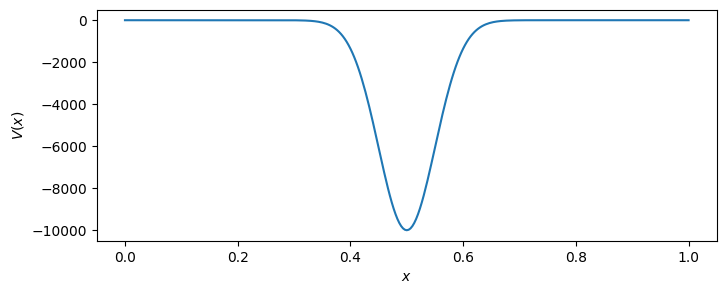

In [6]:
plt.figure(figsize=(8,3))
plt.plot(x,V)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

In [7]:
psi = np.zeros([Nt,Nx])
psi[0] = psi0

In [8]:
psi

array([[0.00000000e+00, 1.48093391e-02, 2.96170542e-02, ...,
        2.96170542e-02, 1.48093391e-02, 1.73191211e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [9]:
@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t][i] + 1j/2 * dt/dx**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j*dt*V[i]*psi[t][i]
        
        normal = np.sum(np.absolute(psi[t+1])**2)*dx
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t+1][i]/normal
        
    return psi

In [10]:
psi_m1 = compute_psi(psi.astype(complex))

0.9999999995490139

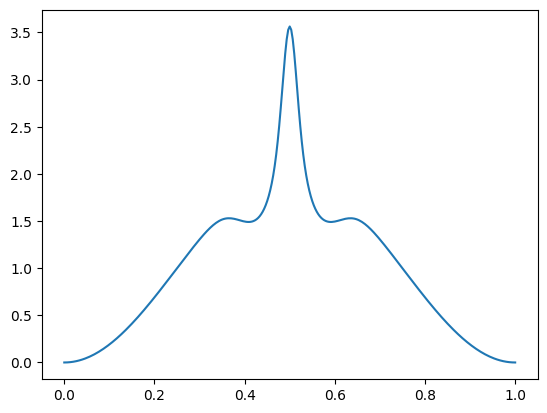

In [11]:
plt.plot(x, np.absolute(psi_m1[5000])**2)
np.sum(np.absolute(psi_m1[10000])**2)*dx

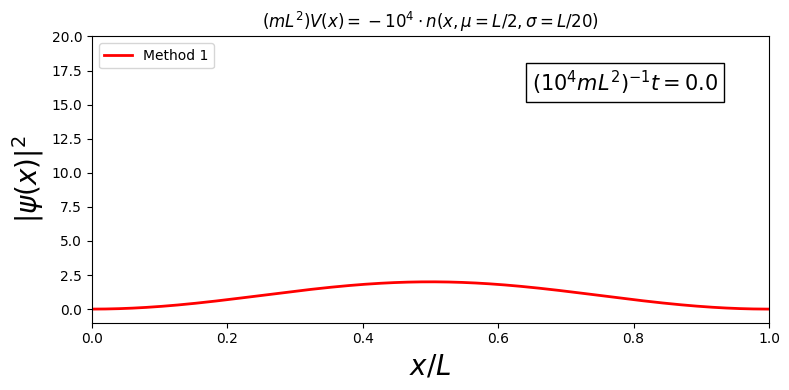

In [13]:
def animate(i):
    ln1.set_data(x, np.absolute(psi_m1[100*i])**2)
    time_text.set_text('$(10^4 mL^2)^{-1}t=$'+'{:.1f}'.format(100*i*dt*1e4))
    
fig, ax = plt.subplots(1,1, figsize=(8,4))
#ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Method 1')
time_text = ax.text(0.65, 16, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 20)
ax.set_xlim(0,1)
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x/L$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=50,dpi=100)